In [1]:
# import necessary libraries
import json, urllib.request
import csv, requests
import branca, folium, pycountry
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pycountry_convert as pc
from datetime import datetime
from folium.features import Choropleth
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline

Load the shape of world map, the source of data can be found below:-
<br>Source of JSON file: https://github.com/python-visualization/folium/tree/master/examples/data

Load the time series for COVID-19 cases, the source of data can be found below:-
<br>Time series data set: https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series


In [2]:
# JSON file to plot a world map
json_url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json'

# Link to download datasets for confirmed cases, death cases and recovered cases.
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"


with urllib.request.urlopen(json_url) as parse_url:
    geo_json = json.loads(parse_url.read().decode())


confirmed_cases = pd.read_csv("{}/{}".format(url, 'time_series_covid19_confirmed_global.csv'), 
                              error_bad_lines=False)
death_reported = pd.read_csv("{}/{}".format(url, 'time_series_covid19_deaths_global.csv'), 
                              error_bad_lines=False)
recovered_cases = pd.read_csv("{}/{}".format(url, 'time_series_covid19_recovered_global.csv'), 
                              error_bad_lines=False)

<br> Checking the 1st 4 columns ('Province/State', 'Country/Region', 'Lat', 'Long') and the last columns (i.e. the latest date posted) whether it is empty.
<br> The output below shown all these 5 columns "False" as there are not empty cells.

In [3]:
confirmed_cases.isnull().any()
#death_reported.isnull().any()
#recovered_cases.isnull().any()

Province/State     True
Country/Region    False
Lat               False
Long              False
1/22/20           False
                  ...  
4/4/20            False
4/5/20            False
4/6/20            False
4/7/20            False
4/8/20            False
Length: 82, dtype: bool

In [4]:
confirmed_cases.columns
#death_reported.columns
#recovered_cases.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20'],
      dtype='object')

<br> Because we need only the latest updates of the total cases, slicing the data is necessary.
<br> We need to perform data cleaning and left only the first  4 columns and last column of datasets.
<br> Please see below.

In [5]:
features = [confirmed_cases.columns[i] for i in (0,1,2,3,-1)]
features

['Province/State', 'Country/Region', 'Lat', 'Long', '4/8/20']

In [6]:
latest_confirmed_cases = confirmed_cases[confirmed_cases[features[-1]] != 0].copy()
latest_confirmed_cases = latest_confirmed_cases[features]
latest_confirmed_cases['LogValue'] = np.log(latest_confirmed_cases[features[-1]])
latest_confirmed_cases.nlargest(10, [features[-1]])

,Province/State,Country/Region,Lat,Long,4/8/20,LogValue
225,NaN,US,37.0902,-95.7129,429052,12.969333
201,NaN,Spain,40.0000,-4.0000,148220,11.906453
137,NaN,Italy,43.0000,12.0000,139422,11.845261
120,NaN,Germany,51.0000,9.0000,113296,11.637759
116,NaN,France,46.2276,2.2137,112950,11.634701
62,Hubei,China,30.9756,112.2707,67803,11.124362
133,NaN,Iran,32.0000,53.0000,64586,11.075753
223,NaN,United Kingdom,55.3781,-3.4360,60733,11.014242
213,NaN,Turkey,38.9637,35.2433,38226,10.551271
23,NaN,Belgium,50.8333,4.0000,23403,10.060619


In [7]:
latest_confirmed_cases.describe()

,Lat,Long,4/8/20,LogValue
count,261.000000,261.000000,261.000000,261.000000
mean,21.502764,22.237237,5789.670498,5.422398
std,24.803658,71.031114,31583.100626,2.527674
min,-51.796300,-135.000000,1.000000,0.000000
25%,7.540000,-23.041800,32.000000,3.465736
50%,23.685000,20.902977,251.000000,5.525453
75%,41.204400,81.000000,1202.000000,7.091742
max,71.706900,178.065000,429052.000000,12.969333


In [8]:
# create a std distribution scales based on logarithmic values
scales = list(round(latest_confirmed_cases.LogValue.quantile([0,0.25,0.5,0.75,1.0])))

# I increase scale of the range by 1 to ensure that every time the maximum value is within the range.
scales[-1] = scales [-1] + 1

scales

[0.0, 3.0, 6.0, 7.0, 14.0]

After creating the scales, I divided the Dataframe into 4 groups: <br>
<ul style="list-style-type:circle;">
    <li>The range of min() value to 25th percentile (lower whisker)</li>
    <li>The range of 25th percentile to median (lower half of interquartile range) </li>
    <li>The range of median to 75th precentile (upper half of interquartile range) </li>
    <li>The range of 75th percentile to max() (upper whisker) </li>
</ul>

In [9]:
### based on the scales created, four division is created.
grouplist = {}

for i in range(0,len(scales)-1):
    grouplist[i] = latest_confirmed_cases[
                    (latest_confirmed_cases.LogValue.values >= scales[i]) & 
                    (latest_confirmed_cases.LogValue.values < scales[i+1])
                ]

# prefix color code for each group     
colorCode = ['#ffffb2','#fecc5c','#fd8d3c','#e31a1c']

In [10]:
# creating the logarithmic scale bar as a legend to be added in folium map
scale_legend = branca.colormap.linear.YlOrRd_09.scale(0, latest_confirmed_cases[features[-1]].max())
scale_legend = scale_legend.to_step(index=scales, method='log')
scale_legend.caption = "Logarithmical scale for COVID-19 confirmed cases"
scale_legend

In [11]:
def addBubbleToMap(df, colorCode):
    
    for i in range(0, len(df)):
        
        if str(df.iloc[i]['Province/State']) == 'nan':
            state = 'N/A'
        else:
            state = df.iloc[i]['Province/State']

        html = """
                    <b>Country/Region</b>: {}<br> 
                    <b>Province/State</b>: {}<br>
                    <b>Total Cases</b>   : {}<br>
            """.format(df.iloc[i]['Country/Region'], state, df.iloc[i][features[-1]])
        
        folium.CircleMarker(
            location=(df.Lat.iloc[i], df.Long.iloc[i]),
                popup=folium.Popup(max_width=200,
                               min_width=10,
                               html=html
                              ),
                color=colorCode,
                fill=True,
                fill_color=colorCode,
                radius=float(df.LogValue.iloc[i]*1.8),
                ).add_to(m)


In [12]:
# Plotting a interactive map for covid19 confirmed cases
m = folium.Map(location=[15,0], tiles='cartodbdark_matter', zoom_start=1.5)

title_html = """
                <h3 align="center" style="font-size:10px">
                    <b>Interactive Maps for Coronavirus COVID-19 Confirmed Cases around the World. (Data as at: {})</b>
                </h3>
            """.format(features[-1])

m.get_root().html.add_child(folium.Element(title_html))

Choropleth(
    geo_data=geo_json,
    name='choropleth',
    key_on='feature.propreties.name',
    fill_color='green',
    nan_fill_color='blue',
    fill_opacity=0.7,
    line_opacity=0.2,
).add_to(m)


scale_legend.add_to(m)

for i in range(0, len(grouplist)):
    addBubbleToMap(grouplist[i], colorCode[i])

m.save('covid19_confirmed_cases_on_map.html')
#display(m)

In [13]:
duplicated_countries = death_reported[death_reported['Country/Region'].duplicated(keep =False)]['Country/Region'].unique()
duplicated_countries

array(['Australia', 'Canada', 'China', 'Denmark', 'France', 'Netherlands',
       'United Kingdom'], dtype=object)

In [14]:
confirmed_cases[confirmed_cases['Country/Region'] == duplicated_countries[2]].head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20
49,Anhui,China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
50,Beijing,China,40.1824,116.4142,14,22,36,41,68,80,...,577,580,580,582,584,585,586,587,587,588
51,Chongqing,China,30.0572,107.8740,6,9,27,57,75,110,...,579,579,579,579,579,579,579,579,579,579
52,Fujian,China,26.0789,117.9874,1,5,10,18,35,59,...,340,343,345,345,349,350,350,350,351,351
53,Gansu,China,37.8099,101.0583,0,2,2,4,7,14,...,138,138,138,138,138,138,138,139,139,139


In [15]:
def rearrangeDataFrame(df, countries):
    for country in countries:
        # summations of selected rows to become one 
        sum_df = df[df['Country/Region'] == str(country)].sum()
        sum_df['Province/State'] = country
    
        # append the row to the main dataFrame
        df = df[df['Country/Region'] != country].append(sum_df, ignore_index = True) # append to last rows
    
    # Combine Province and Region.  Because the following data needs to use Country as representative.
    df['Country'] = df['Province/State']                                                                     
    df['Country'] = df.Country.fillna(df[df['Province/State'].isna()]['Country/Region'])
    
    # Move country columns to 1st column
    cols = list(df.columns)
    cols = [cols[-1]] + [cols[-2]]
    
    return df[cols]

Theses four coutnries: **'Denmark'**, **'France'**, **'Netherlands'** and **'United Kingdom'** countains outside-country-territories.
<br> Since these territories each has separated coordinates far away from its country.  Hence, it is better to treat it as a separate region and not combining them with their respective countries.

In [16]:
new_confirmed_cases = rearrangeDataFrame(confirmed_cases.copy(), duplicated_countries[0:3])
new_death_reported = rearrangeDataFrame(death_reported.copy(), duplicated_countries[0:3])
new_recovered_cases = rearrangeDataFrame(recovered_cases.copy(), duplicated_countries[0:3])

new_confirmed_cases[new_confirmed_cases.Country.str.contains('Australia')]

,Country,4/8/20
207,Australia,6010


In [17]:
# Check if number of row of countries is the same
print("Total rows in confirmed cases: {}".format(new_confirmed_cases.shape[0]))
print("Total rows in death cases:     {}".format(new_death_reported.shape[0]))
print("Total rows in recovered cases: {}".format(new_recovered_cases.shape[0]))

Total rows in confirmed cases: 210
Total rows in death cases:     210
Total rows in recovered cases: 210


In [18]:
# create a lit of countries
countries = [x for x in new_confirmed_cases.Country]

# create a list of columns
cols = list(new_confirmed_cases.columns)
    
new_confirmed_cases.nlargest(10, features[-1])
#new_death_reported.nlargest(10, features[-1])
#new_recovered_cases.nlargest(10, features[-1])

,Country,4/8/20
173,US,429052
149,Spain,148220
85,Italy,139422
68,Germany,113296
64,France,112950
209,China,82809
81,Iran,64586
171,United Kingdom,60733
161,Turkey,38226
15,Belgium,23403


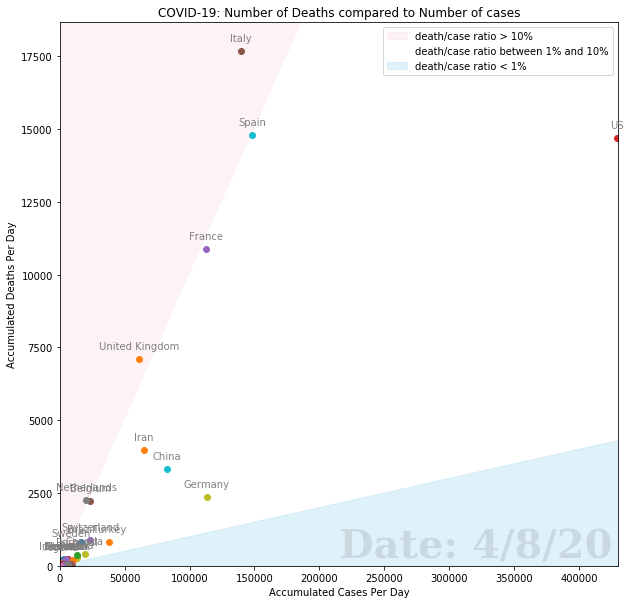

In [19]:
# Plotting scatter graph in comparison with death cases and confirmed cases
fig = plt.figure()
ax = fig.add_subplot(111)

col = cols[-1]

# Initialize styles
style = dict(size=10, color='gray')

# set x-axis and y-axis
x_lim = int(new_confirmed_cases[cols[-1]].max() + 1e3)
y_lim = int(new_death_reported[cols[-1]].max() + 1e3)
plt.axis([0,x_lim,0,y_lim])

# range to plot fill area
xrange = [10*x for x in range(0, x_lim)]
yrange = [y for y in range(0, x_lim)]
xrange2 = [100*x for x in range(0, x_lim)]

# resize graph
plt.gcf().set_size_inches(10,10, forward=False)

# label the figure
plt.title('COVID-19: Number of Deaths compared to Number of cases')
    
# Label the axes
plt.xlabel('Accumulated Cases Per Day')
plt.ylabel('Accumulated Deaths Per Day')

# plot fill area
area1 = plt.fill_between(xrange, y_lim, color="crimson", alpha=0.05) # plot crimson area where death/case ratio is > 10%
area2 = plt.fill_between(xrange, yrange, color="white", alpha=1) # plot area where death/case ratio is < 10%
area3 = plt.fill_between(xrange2, yrange, color="skyblue", alpha=0.25) # plot skyblue area where death/case ratio is < 1%

plt.legend([area1,area2,area3],
           ["death/case ratio > 10%", "death/case ratio between 1% and 10%", "death/case ratio < 1%"],
           loc='best', bbox_to_anchor=(1, 1)
          )

for country in countries:
    x = new_confirmed_cases[col][new_confirmed_cases.Country == country].values[0]
    y = new_death_reported[col][new_death_reported.Country == country].values[0]
    
    ax.scatter(x, y, label=country)
    if (x > 1e3) and (y > 200):
        ax.annotate(country, 
                    xy = (float(x),float(y)),
                    textcoords = "offset points", # how to position the text
                    xytext = (0,10), # distance from text to points (x,y)
                    ha = 'center',
                    **style
                   )

ax.text((x_lim/2), 1, 
    "Date: {}".format(col), 
    horizontalalignment= 'left', 
    verticalalignment='bottom',
    fontsize = 40,
    fontweight = 'bold',
    family="serif",
    alpha = 0.1
)

plt.savefig('ScatterPlot.png')
plt.show()

<br> Load hospital beds indicator from OECD DATA
<br> Citation: OECD (2020), Hospital beds (indicator). doi: 10.1787/0191328e-en (Accessed on 03 April 2020)
<br>Source of data for hospital beds for OECD DATA: https://data.oecd.org/healtheqt/hospital-beds.htm

In [20]:
#Main Pull
payload = {'contentType': 'csv','detail': 'code', 'separator': 'comma', 'csv-lang':'en'}
r = requests.get('https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HOSPITALBED.../OECD', params=payload)
r.url

'https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HOSPITALBED.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en'

In [21]:
r.text.splitlines()[0]

'ï»¿"LOCATION","INDICATOR","SUBJECT","MEASURE","FREQUENCY","TIME","Value","Flag Codes"'

Note that there is an alien wording on the front of **"LOCATION"**.  The columns will be modified later.

In [22]:
#writing the main pull
output_reader = csv.reader(r.text.splitlines())
with open('pdb_data_no_dups.csv', 'w') as csvfile:
    csv_writer = csv.writer(csvfile)
    for row in output_reader:
        csv_writer.writerow(row)

In [23]:
# reading the csv file that just pulled and 
beds = pd.read_csv("pdb_data_no_dups.csv")
beds.columns = ['LOCATION','INDICATOR','SUBJECT','MEASURE','FREQUENCY','TIME','Value','Flag Codes']

#the latest year recorded for bed indicator
# beds.TIME.max()

beds.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,HOSPITALBED,TOT,1000HAB,A,1960,9.65,NaN
1,AUS,HOSPITALBED,TOT,1000HAB,A,1961,9.48,NaN
2,AUS,HOSPITALBED,TOT,1000HAB,A,1962,9.38,NaN
3,AUS,HOSPITALBED,TOT,1000HAB,A,1963,9.36,NaN
4,AUS,HOSPITALBED,TOT,1000HAB,A,1964,9.23,NaN


In [24]:
# reconfirm the datas
print("Total rows in confirmed cases: {}".format(new_confirmed_cases.shape[0]))
print("Total rows in death cases:     {}".format(new_death_reported.shape[0]))
print("Total rows in recovered cases: {}".format(new_recovered_cases.shape[0]))

Total rows in confirmed cases: 210
Total rows in death cases:     210
Total rows in recovered cases: 210


In [25]:
new_confirmed_cases[new_confirmed_cases.Country.str.contains('China')]

,Country,4/8/20
209,China,82809


In [26]:
# merging confirmed cases table, death cases table and recovered cases table
merge_cases = new_confirmed_cases[['Country', cols[-1]]].merge(new_death_reported[['Country', cols[-1]]], on='Country', how='inner')
merge_cases = merge_cases.merge(new_recovered_cases[['Country', cols[-1]]], on='Country', how='inner')
print(" Columns before rename: {}".format(merge_cases.columns))

# rename columns to become meaningful field
merge_cases.columns = ['Country','confirmed','deaths','recovered']
print(" Columns after rename: {}".format(merge_cases.columns))

 Columns before rename: Index(['Country', '4/8/20_x', '4/8/20_y', '4/8/20'], dtype='object')
 Columns after rename: Index(['Country', 'confirmed', 'deaths', 'recovered'], dtype='object')


In [27]:
# recovery rate
merge_cases['active'] = merge_cases.confirmed - merge_cases.deaths - merge_cases.recovered
merge_cases['recovery_rate'] = merge_cases.recovered / merge_cases.confirmed * 100
merge_cases.head()

,Country,confirmed,deaths,recovered,active,recovery_rate
0,Afghanistan,444,14,29,401,6.531532
1,Albania,400,22,154,224,38.500000
2,Algeria,1572,205,237,1130,15.076336
3,Andorra,564,23,52,489,9.219858
4,Angola,19,2,2,15,10.526316


Total countries become lesser by 1 after **2010**.  
<br> This implies that one country has stopped updated its data from **2011** onwards

In [28]:
# Assign all the country code into a list
locations = list(beds.LOCATION.unique())

# Assign the subjects of bed usage into a list
subjects = list(beds.SUBJECT.unique())

beds = beds[beds.TIME >= 2010]  # We can change the year here to verify if the country code has been reduced
number_of_countries_recorded_in_bed_datasets = len(beds.LOCATION.unique())
#number_of_countries_recorded_in_bed_datasets

In [29]:
def filterForLatestNumOfBed(df, locations=locations, subjects=subjects):
    for location in locations:
        #print(country)
        for subject in subjects:
            #print(subject)
            new_df = df[df.LOCATION.str.contains(location) & df.SUBJECT.str.contains(subject)]
            index = list(new_df[new_df.TIME != new_df.TIME.max()].index)
            df = df.drop(index)
            #print(index)
        
    return df

In [30]:
beds_2010_later = filterForLatestNumOfBed(beds[beds.TIME >= 2010].copy())

# Total beds per 1000 inhabitants by country code
beds_data = beds_2010_later.Value.groupby(beds.LOCATION).sum().sort_index
beds_data

<bound method Series.sort_index of LOCATION
AUS     4.26
AUT    13.43
BEL    11.98
BRA     2.30
CAN     4.79
CHE     9.02
CHL     4.20
CHN     4.34
COL     1.71
CRI     1.13
CZE    11.68
DEU    15.30
DNK     5.39
ESP     5.76
EST     8.67
FIN     6.47
FRA     9.91
GBR     5.03
GRC     8.55
HUN    12.16
IDN     1.04
IND     0.53
IRL     6.07
ISL     5.65
ISR     5.58
ITA     5.89
JPN    23.46
KOR    20.72
LTU    13.02
LUX     8.95
LVA    10.12
MEX     2.79
NLD     7.15
NOR     7.87
NZL     5.50
POL    12.12
PRT     7.28
RUS     8.05
SVK    11.54
SVN     9.36
SWE     4.69
TUR     5.64
USA     5.42
ZAF     2.32
Name: Value, dtype: float64>

In [31]:
countries_with_recorded_beds = [pycountry.countries.get(alpha_3=loc).name for loc in locations]
countries_with_recorded_beds

['Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Czechia',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Japan',
 'Korea, Republic of',
 'Luxembourg',
 'Mexico',
 'Netherlands',
 'New Zealand',
 'Norway',
 'Poland',
 'Portugal',
 'Slovakia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'United Kingdom',
 'United States',
 'Brazil',
 'Chile',
 'China',
 'Estonia',
 'India',
 'Indonesia',
 'Israel',
 'Russian Federation',
 'Slovenia',
 'South Africa',
 'Colombia',
 'Latvia',
 'Lithuania',
 'Costa Rica']

Unfortunately, in merge_cases table there's two country which is using different name from bed datas, which is:

<ul style="list-style-type:number;">
    <li>'US' --> United States</li>
    <li>'Russia' --> Russian Federation </li>
</ul>

Plse uncomment this to see that the list of country in merge_cases for comparison

In [32]:
#merge_cases.Country.unique() 

In [33]:
df= merge_cases.copy()

# Change the naming for Russian Federation and United States to access merge_cases
for x in range(0, len(countries_with_recorded_beds)):
    if countries_with_recorded_beds[x] == 'Russian Federation':
        countries_with_recorded_beds[x] = 'Russia'
    elif countries_with_recorded_beds[x] == 'United States':
        countries_with_recorded_beds[x] = 'US'
    else:
        continue

# Identifying the indices to slice out the unecessary data.
# From here we will only focus on the countries which has records for number of beds        
indices = [df[df.Country == country].index[0] for country in df.Country if country in countries_with_recorded_beds]
cases_with_recorded_beds = df.iloc[indices]

In [34]:
# It shows that we have almost all the countries in our list except for one: Replic of Korea
print("# of Countries with recorded beds data in OCED: {}".format(number_of_countries_recorded_in_bed_datasets))
print("# of Countries after sliced out from COVID-19 data: {}".format(cases_with_recorded_beds.shape[0]))

# of Countries with recorded beds data in OCED: 44
# of Countries after sliced out from COVID-19 data: 43


In [35]:
# identify all the unique countires with recorded beds
countries_with_recorded_beds = list(cases_with_recorded_beds.Country.unique())
location_code = []

for country in countries_with_recorded_beds:
    if country == 'US':
        country = 'United States'
    location_code.append(pc.country_name_to_country_alpha3(country, cn_name_format="default"))

# Add columns with the country code created    
cases_with_recorded_beds['Location'] = location_code

# Add in bed datas
cases_with_recorded_beds['beds'] = [float(beds[beds.LOCATION.str.contains(loc)].Value.sum()) for loc in location_code]
cases_with_recorded_beds = cases_with_recorded_beds.sort_values(by= "confirmed", ascending = False) 

# Identify top 10 cases
top_10_cases = cases_with_recorded_beds.head(10)
top_10_location = list(top_10_cases.Location.unique())
cases_with_recorded_beds.nlargest(10, 'confirmed')

/home/jyong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/jyong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Country,confirmed,deaths,recovered,active,recovery_rate,Location,beds
173,US,429052,14695,23559,390798,5.490943,USA,39.55
149,Spain,148220,14792,48021,85407,32.398462,ESP,46.21
85,Italy,139422,17669,26491,95262,19.000588,ITA,49.49
68,Germany,113296,2349,46300,64647,40.866403,DEU,124.91
64,France,112950,10869,21254,80827,18.817176,FRA,83.06
209,China,82809,3337,77567,1905,93.669770,CHN,27.32
171,United Kingdom,60733,7097,135,53501,0.222284,GBR,27.64
161,Turkey,38226,812,1846,35568,4.829174,TUR,43.40
15,Belgium,23403,2240,4681,16482,20.001709,BEL,112.41
154,Switzerland,23280,895,9800,12585,42.096220,CHE,74.32


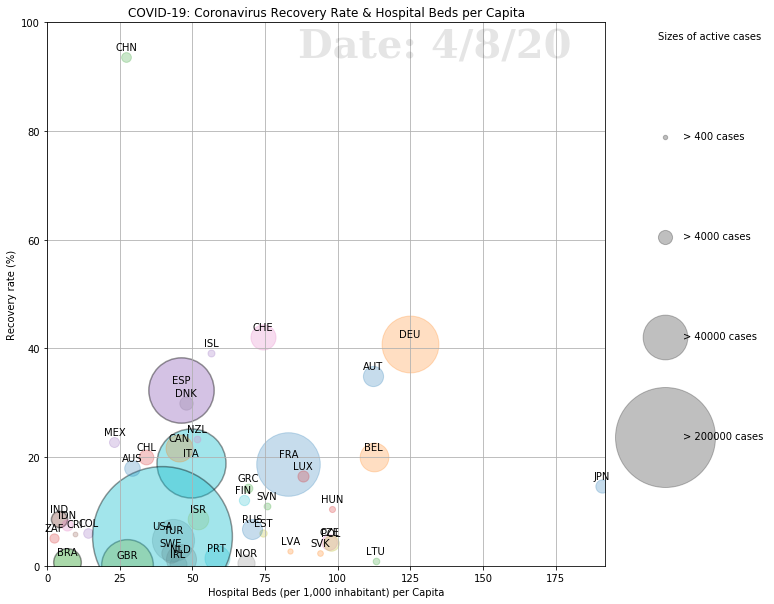

In [50]:
fig = plt.figure()

# Initialize styles
style = dict(size='medium', color='black')

# set x-axis and y-axis
x_lim = int(cases_with_recorded_beds.beds.max() + 2)
y_lim = int(100)
plt.axis([0,x_lim,0,y_lim])

# resize graph
plt.gcf().set_size_inches(10,10, forward=False)

# label the figure
plt.title('COVID-19: Coronavirus Recovery Rate & Hospital Beds per Capita')
    
# Label the axes
plt.xlabel('Hospital Beds (per 1,000 inhabitant) per Capita')
plt.ylabel('Recovery rate (%)')

plt.grid(True,axis='both')

# Plotting multiple bubbles
for location in location_code:
    isLocation = cases_with_recorded_beds.Location.str.contains(location)
    x = cases_with_recorded_beds[isLocation].beds.values[0]
    y = cases_with_recorded_beds[isLocation].recovery_rate.values[0]
    size = cases_with_recorded_beds[isLocation].active.values[0]
    
    # Highlight the number of beds that is less than active cases
    if x*1000 < size:
        plt.scatter(x, y, s=size*0.05, alpha=0.4, linewidths=1.5, edgecolor ='black')
    else:
        plt.scatter(x, y, s=size*0.05, alpha=0.25)

# Label country code on bubbles
for row in range(0, cases_with_recorded_beds.shape[0]):
    plt.annotate(cases_with_recorded_beds.Location.iloc[row], 
                xy = (cases_with_recorded_beds.beds.iloc[row],cases_with_recorded_beds.recovery_rate.iloc[row]),
                textcoords = "offset points", # how to position the text
                xytext = (0,10), # distance from text to points (x,y)
                horizontalalignment= 'center', 
                verticalalignment='center',
                **style
                )

# Display text of data as dated.
plt.text(x_lim*0.45, y_lim-1, 
    "Date: {}".format(col), 
    horizontalalignment= 'left', 
    verticalalignment='top',
    fontsize = 40,
    fontweight = 'bold',
    family="serif",
    alpha = 0.1
)

# Create legend for bubble plot
for area in [4e2, 4e3, 4e4, 2e5]:
    plt.scatter([], 
                [], 
                c ='k', alpha=0.25, 
                s=area*0.05, 
                label="> {} cases".format(int(area))
               )

plt.legend(scatterpoints=1, frameon=False, labelspacing=9, loc="best", title="Sizes of active cases", bbox_to_anchor=(1.3, 1))

plt.savefig('BubblePlot.png')
plt.show()

In [37]:
cols = confirmed_cases.columns

In [38]:
# slicing the data and retain the daily record
confirmed_cases_over_time = confirmed_cases.loc[:,cols[4]:cols[-1]]
death_reported_over_time = death_reported.loc[:,cols[4]:cols[-1]]
recoveries_over_time = recovered_cases.loc[:,cols[4]:cols[-1]]
days = confirmed_cases_over_time.keys()

In [39]:
# obtain the total cases for daily basis
sum_of_confirmed_over_time = confirmed_cases_over_time.sum()
sum_of_deaths_over_time = death_reported_over_time.sum()
sum_of_recoveries_over_time = recoveries_over_time.sum()
days_since_1_22 = np.array([i for i in range(len(days))]).reshape(-1, 1)

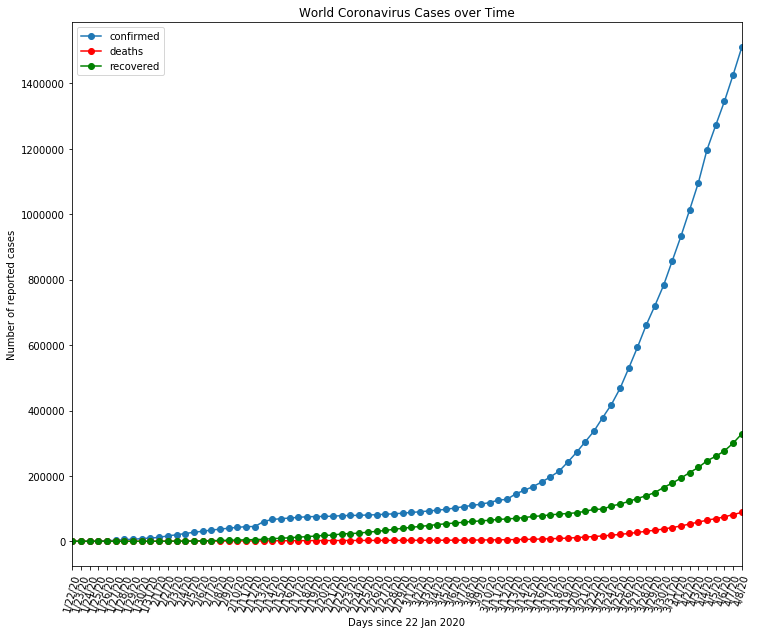

In [40]:
plt.figure(figsize=(12,10))
plt.plot(sum_of_confirmed_over_time, marker='o')
plt.plot(sum_of_deaths_over_time, marker='o', color='r')
plt.plot(sum_of_recoveries_over_time, marker='o', color='g')
plt.title('World Coronavirus Cases over Time')
plt.legend(['confirmed','deaths', 'recovered'])
plt.xticks(rotation=75)
plt.xlim(0,days[-1])

# Label the axes
plt.xlabel('Days since 22 Jan 2020')
plt.ylabel('Number of reported cases')

plt.savefig('WorldCoronavirusCasesOverTime.png')
plt.show()

The linear regression formula are expected as:
\begin{align*}
y = a + b * x
\end{align*}
where:
<ul style="list-style-type:number;">
    <li><b>a</b> is the value of <b>constant</b></li>
    <li><b>b</b> is the value of <b>days</b></li>
</ul>



By converting the exponential function into a linear function, we will get:
\begin{align*}
log(x(t)) = log(x_0) + log(b)*t
\end{align*}
where:
\begin{align*}
x_0 = e^a
\end{align*}
<br>the **linear regression's a** is the **log of initial value**
<br>the **linear regression's b** is the **log of growth factor**

By applying inverse log to the equation, we will have the actual formula for the coronavirus pandemic
\begin{align*}
x(t) = e^a *b^t
\end{align*}

In [49]:
def linearRegressionModel(x_data, y_data):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, random_state = 0)
    X_train = pd.DataFrame(X_train)
    X_test = pd.DataFrame(X_test)
    
    #implement linear regression
    model = LinearRegression()
    reg = model.fit(X_train,y_train)    
    
    #make predictions and find the rmse
    preds = model.predict(X_test)
    #print(preds)
    rms=np.sqrt(np.mean(np.power((np.array(y_test)-np.array(preds)),2)))
    
    
    return reg, rms, preds

In [42]:
confirmed_reg, confirmed_rms, confirmed_preds = linearRegressionModel(days_since_1_22, np.log(sum_of_confirmed_over_time))
deaths_reg, deaths_rms, deaths_preds = linearRegressionModel(days_since_1_22, np.log(sum_of_deaths_over_time))
recovery_reg, recovery_rms, recovery_preds = linearRegressionModel(days_since_1_22, np.log(sum_of_recoveries_over_time))

In [43]:
print("RMS determined for confirmed cases: {}".format(confirmed_rms))
print("RMS determined for death reported: {}".format(deaths_rms))
print("RMS determined for recovery cases: {}".format(recovery_rms)) # this is invalid for recovery cases

RMS determined for confirmed cases: 0.6590924307563436
RMS determined for death reported: 0.5698045326068973
RMS determined for recovery cases: 1.0645497056887319


In [44]:
extra_day_for_predictions = 14
future_forecast = np.array([i for i in range(len(days_since_1_22)+extra_day_for_predictions)]).reshape(-1, 1)

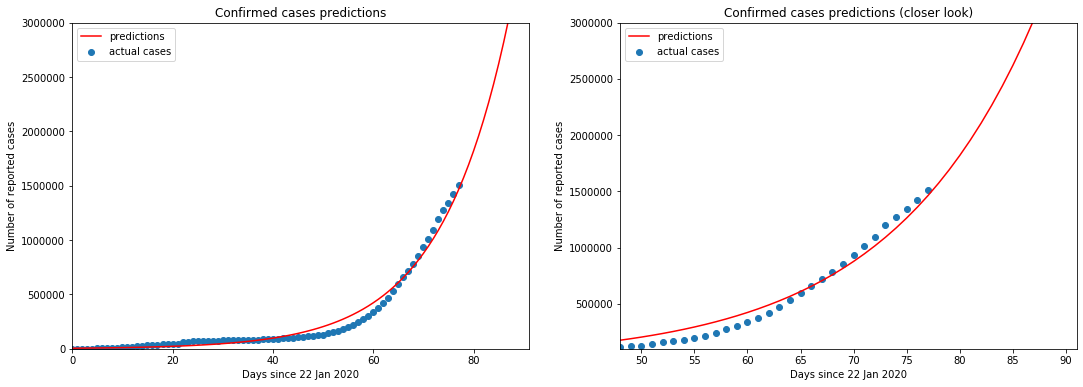

In [45]:
fig, axs = plt.subplots(1, 2)
plt.gcf().set_size_inches(18,6, forward=False)
axs[0].plot(future_forecast, np.exp(confirmed_reg.coef_)**future_forecast * np.exp(confirmed_reg.intercept_), color ="red")
axs[0].scatter(days_since_1_22, sum_of_confirmed_over_time)
axs[0].axis([0,future_forecast[-1],0,30e5])
axs[0].set_title('Confirmed cases predictions')
# Label the axes
axs[0].set_xlabel('Days since 22 Jan 2020')
axs[0].set_ylabel('Number of reported cases')
axs[0].legend(['predictions', 'actual cases'])

#plot another graph for closer look
axs[1].plot(future_forecast, np.exp(confirmed_reg.coef_)**future_forecast * np.exp(confirmed_reg.intercept_), color ="red")
axs[1].scatter(days_since_1_22, sum_of_confirmed_over_time)
axs[1].axis([future_forecast[-44],future_forecast[-1],1e5,30e5])
axs[1].set_title('Confirmed cases predictions (closer look)')
# Label the axes
axs[1].set_xlabel('Days since 22 Jan 2020')
axs[1].set_ylabel('Number of reported cases')
axs[1].legend(['predictions', 'actual cases'])

plt.savefig('LinearRegressionPredictionPlot.png')
plt.show()